In [23]:
from math import sqrt, exp, pi, cos, sin
import random
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [71]:
class Robot:
    """
    A Robot class that simulates a robot in a 2D world.

    Attributes:
        world_size (float): Size of the square world.
        landmarks (list of tuples): List of landmark coordinates [(x1, y1), (x2, y2), ...].
        x (float): Current x-coordinate of the robot.
        y (float): Current y-coordinate of the robot.
        orientation (float): Current orientation of the robot in radians.
        forward_noise (float): Noise level for forward movement.
        turn_noise (float): Noise level for turning.
        sense_noise (float): Noise level for sensing landmarks.
    """
    def __init__(self, world_size, landmarks):
        self.x = random.random() * world_size
        self.y = random.random() * world_size
        self.orientation = random.random() * 2.0 * pi
        self.forward_noise = 0.0
        self.turn_noise = 0.0
        self.sense_noise = 0.0
        self.world_size = world_size
        self.landmarks = landmarks

    def set(self, new_x, new_y, new_orientation):
        if new_x < 0 or new_x >= self.world_size:
            raise ValueError("X coordinate out of bound")
        if new_y < 0 or new_y >= self.world_size:
            raise ValueError("Y coordinate out of bound")
        if new_orientation < 0 or new_orientation >= 2 * pi:
            raise ValueError("Orientation must be in [0..2pi]")
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)

    def set_noise(self, forward_noise, turn_noise, sense_noise):
        self.forward_noise = float(forward_noise)
        self.turn_noise = float(turn_noise)
        self.sense_noise = float(sense_noise)

    def sense(self):
        Z = []
        for landmark in self.landmarks:
            dist = sqrt((self.x - landmark[0]) ** 2 + (self.y - landmark[1]) ** 2)
            dist += random.gauss(0.0, self.sense_noise)
            Z.append(dist)
        return Z

    def move(self, turn, forward):
        if forward < 0:
            raise ValueError("Robot cannot move backwards")

        orientation = self.orientation + float(turn) + random.gauss(0.0, self.turn_noise)
        orientation %= 2 * pi

        dist = float(forward) + random.gauss(0.0, self.forward_noise)
        x = self.x + cos(orientation) * dist
        y = self.y + sin(orientation) * dist
        x %= self.world_size
        y %= self.world_size

        res = Robot(self.world_size, self.landmarks)
        res.set(x, y, orientation)
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
        return res

    def measurement_prob(self, measurement):
        prob = 1.0
        for i in range(len(self.landmarks)):
            dist = sqrt((self.x - self.landmarks[i][0]) ** 2 + (self.y - self.landmarks[i][1]) ** 2)
            prob *= self.gaussian(dist, self.sense_noise, measurement[i])
        return prob

    @staticmethod
    def gaussian(mu, sigma, x):
        return exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / sqrt(2.0 * pi * (sigma ** 2))

In [72]:

class CustomParticleFilter:
    """
    A Particle Filter class for implementing localization in a 2D world.

    Attributes:
        num_particles (int): Number of particles in the filter.
        world_size (float): Size of the square world.
        landmarks (list of tuples): List of landmark coordinates [(x1, y1), (x2, y2), ...].
        particles (list of Robot): List of particles representing possible states of the robot.
    """
    def __init__(self, num_particles, world_size, landmarks):
        self.num_particles = num_particles
        self.world_size = world_size
        self.landmarks = landmarks
        self.particles = [self.create_particle() for _ in range(num_particles)]

    def create_particle(self):
        particle = Robot(self.world_size, self.landmarks)
        particle.set_noise(0.05, 0.05, 5.0)
        return particle

    def move_particles(self, turn, forward):
        self.particles = [particle.move(turn, forward) for particle in self.particles]

    def resample_particles(self, measurements):
        weights = [particle.measurement_prob(measurements) for particle in self.particles]
        max_weight = max(weights)

        resampled_particles = []
        index = int(random.random() * self.num_particles)
        beta = 0.0

        for _ in range(self.num_particles):
            beta += random.random() * 2.2 * max_weight
            while beta > weights[index]:
                beta -= weights[index]
                index = (index + 1) % self.num_particles
            resampled_particles.append(self.particles[index])

        self.particles = resampled_particles

In [232]:
class Simulation:
    """
    A Simulation class to simulate robot motion and localization using a particle filter.

    Attributes:
        world_size (float): Size of the square world.
        landmarks (list of tuples): List of landmark coordinates
        target (Robot): The target robot being tracked in the simulation.
        particle_filter (ParticleFilter): Particle filter used for localization.
    """
    def __init__(self, world_size, landmarks, num_particles, forward_noise, turn_noise, sense_noise):
        self.world_size = world_size
        self.landmarks = landmarks
        self.target = Robot(world_size, landmarks)
        self.target.set_noise(forward_noise, turn_noise, sense_noise)
        self.target.set(30.0, 50.0, pi / 2)
        self.particle_filter = CustomParticleFilter(num_particles, world_size, landmarks)

    def plot_world(self, run_no):
        plt.clf()
        landmark_x, landmark_y = zip(*self.landmarks)
        plt.scatter(landmark_x, landmark_y, color="b", marker='s', label="Landmarks")
        particle_x = [particle.x for particle in self.particle_filter.particles]
        particle_y = [particle.y for particle in self.particle_filter.particles]
        plt.scatter(particle_x, particle_y, color="r", alpha=0.5, label="Particles")
        plt.scatter(self.target.x, self.target.y, color="g", label="True Position", marker="x", s=100)
        plt.xlim(0, self.world_size)
        plt.ylim(0, self.world_size)
        plt.text(1, 1, f"Run {run_no+1}", fontsize=15)
        plt.xlabel("x-direction")
        plt.ylabel("y-direction")
        plt.title("Particle Filter - Step {}".format(run_no+1))
        plt.legend()
        plt.savefig(f'snaps/snap_{run_no}.png', bbox_inches='tight')


    def run(self, runs, step_size, turn_size):
        for run_no in range(runs):
            self.plot_world(run_no)
            self.target = self.target.move(turn_size, step_size)
            measurements = self.target.sense()
            self.particle_filter.move_particles(turn_size, step_size)
            self.particle_filter.resample_particles(measurements)

In [233]:
fig = plt.figure(figsize=(10, 10))

world_size = 100.0
landmarks = [[20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]]
num_particles = 50
forward_noise = 0.05
turn_noise = 0.05
sense_noise = 2.0

<Figure size 1000x1000 with 0 Axes>

In [234]:
simulation = Simulation(world_size, landmarks, num_particles, forward_noise, turn_noise, sense_noise)

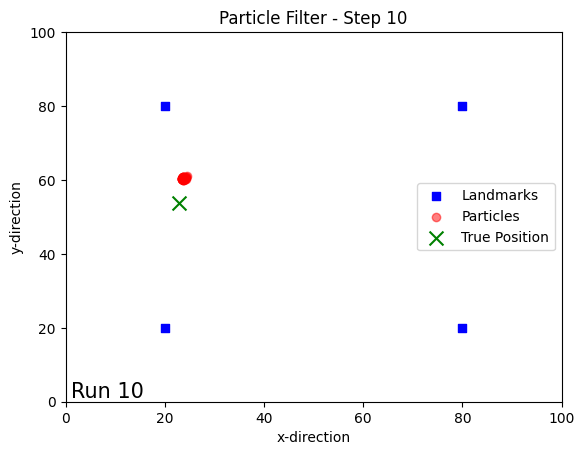

In [235]:
simulation.run(runs=10, step_size=1, turn_size=0.2)
plt.close(fig)

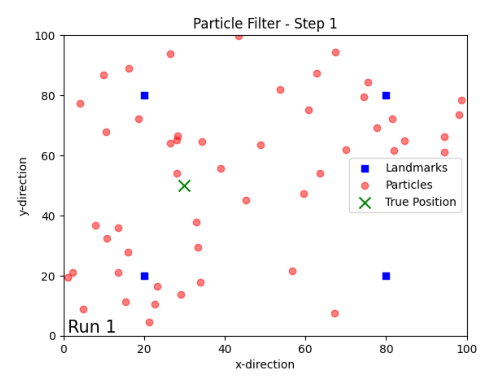

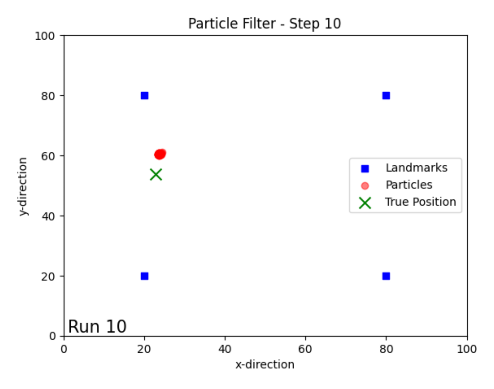

In [237]:
import matplotlib.image as mpimg
%matplotlib inline

image1 = mpimg.imread('snaps/snap_0.png')
image2 = mpimg.imread('snaps/snap_9.png')

plt.imshow(image1)
plt.axis('off')
plt.show()
plt.imshow(image2)
plt.axis('off')
plt.show()

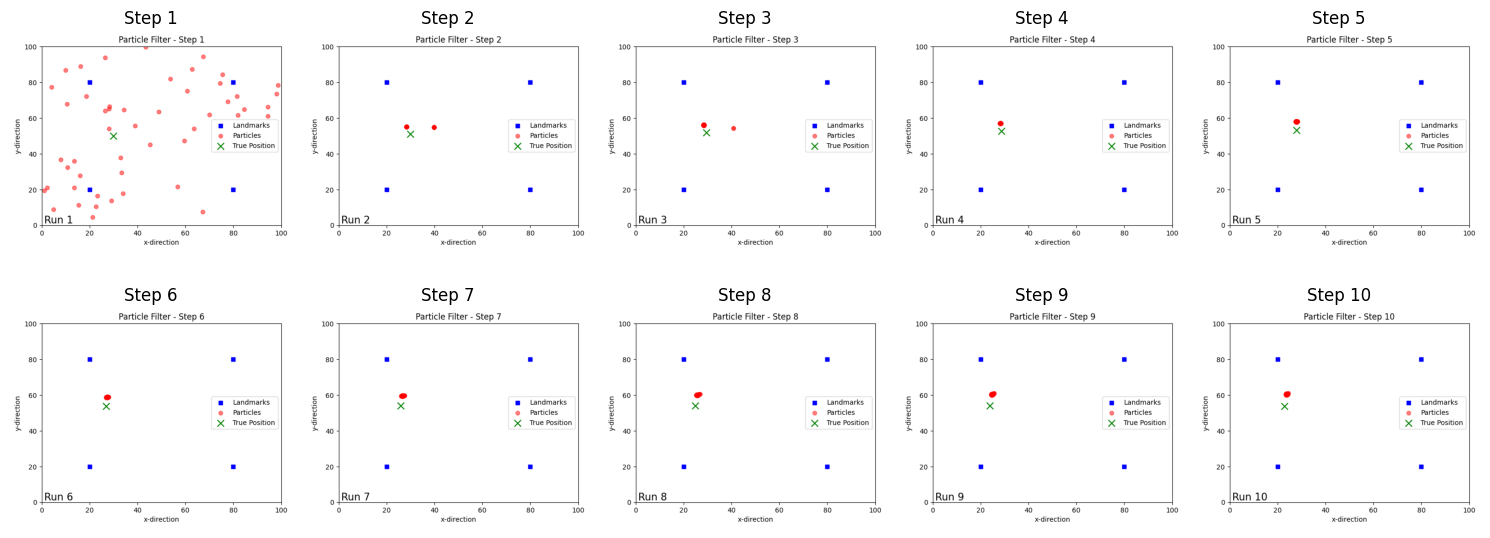

In [239]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    img_path = f'snaps/snap_{i}.png'
    img = mpimg.imread(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Step {i+1}")

plt.tight_layout()
plt.show()
